In [7]:
import time
import numpy as np
import matplotlib.pyplot as plt
import oursin as urchin
import atlaselectrophysiology.load_histology as hist
import scipy.ndimage
import nrrd

In [2]:
urchin.setup()

(URN) connected to server
Login sent with ID: bb02b571, copy this ID into the renderer to connect.


In [3]:
hist_paths = hist.download_histology_data('KS086', 'cortexlab')

In [4]:
hist_paths

[WindowsPath('C:/Users/Dan/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS086/histology/STD_ds_KS086_GR.nrrd'),
 WindowsPath('C:/Users/Dan/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS086/histology/STD_ds_KS086_RD.nrrd')]

In [5]:
# Convert the TIFF files into numpy arrays
import SimpleITK as sitk

In [8]:
reader = sitk.ImageFileReader()
reader.SetImageIO("TIFFImageIO")
reader.SetFileName(str('C:/Users/Dan/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS086/histology/STD_ds_KS086_GR.tif'))
img = reader.Execute()

new_img = sitk.PermuteAxes(img, [2, 1, 0])
new_img = sitk.Flip(new_img, [True, False, False])
new_img.SetSpacing([1, 1, 1])
writer = sitk.ImageFileWriter()
writer.SetImageIO("NrrdImageIO")
writer.SetFileName(str('C:/Users/Dan/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS086/histology/STD_ds_KS086_RD.tif'))
writer.Execute(new_img)

# Load files are convert to a single volume
We want the track data to be in the red channel and the regular data to be in green

In [8]:
data_gr, meta = nrrd.read(str(hist_paths[0]))
data_rd, meta = nrrd.read(str(hist_paths[1]))

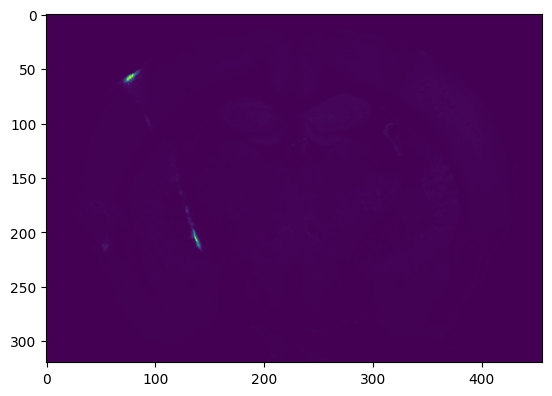

In [9]:
plt.imshow(data_rd[258,:,:])

In [10]:
# median filter the red probe track
data_rd_mdf = scipy.ndimage.median_filter(data_rd,3)

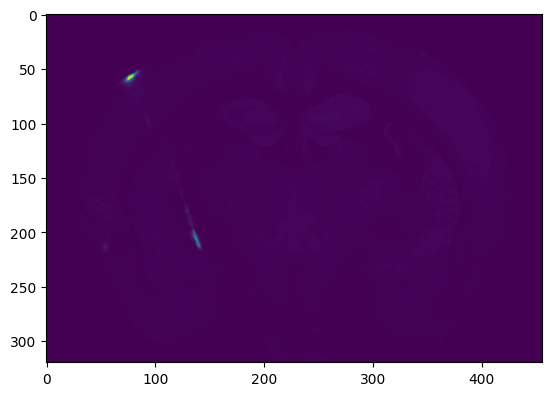

In [11]:
plt.imshow(data_rd_mdf[258,:,:])

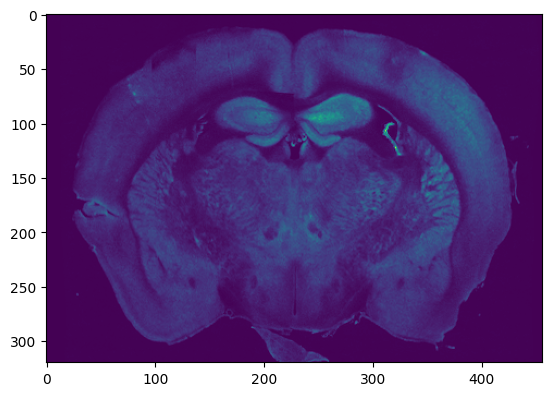

In [12]:
plt.imshow(data_gr[258,:,:])

In [13]:
data_gr_norm = data_gr / 1500 * 255
data_rd_norm = np.power(data_rd,1.3)
data_rd_norm[data_rd_norm<5000] = 0
data_rd_norm = data_rd_norm / 10000 * 255
data_rd_norm[data_rd_norm<=128] = 0
data_rd_norm[data_rd_norm>128] = 255

In [14]:
data = np.empty((528,320,456,4),dtype=np.uint8)
data[:,:,:,3] = 255
data[:,:,:,1] = data_gr_norm
data[:,:,:,0] = data_rd_norm

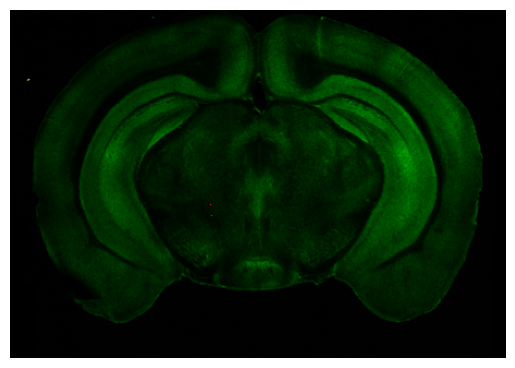

In [15]:
plt.axis('off')
plt.imshow(data[323,:,:,:])

(array([5.5832020e+07, 1.4202141e+07, 5.2012820e+06, 1.2278430e+06,
        3.8524500e+05, 1.4565600e+05, 4.0533000e+04, 9.0400000e+03,
        1.2700000e+03, 2.5100000e+02]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

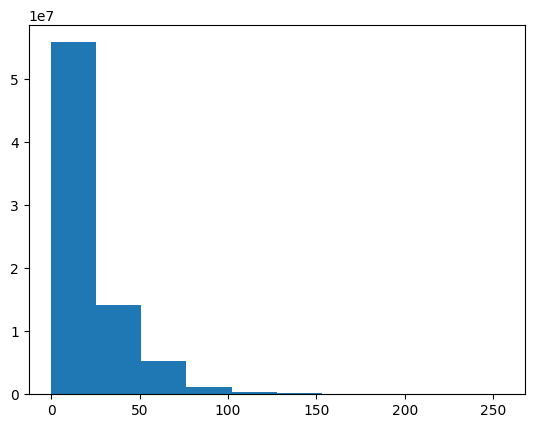

In [16]:
plt.hist(data_gr_norm[data_gr_norm<=255].flatten())

(array([7.7025254e+07, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 2.0506000e+04]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

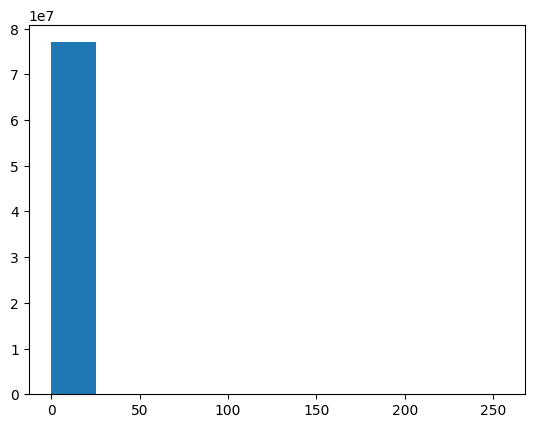

In [17]:
plt.hist(data_rd_norm[data_rd_norm<=255].flatten())

# Convert the histology data to a color-map-able dataset
What we'll do is re-scale the green values to some range of greens from black->bright green then we'll take the red channel and just check if it's >10 or so and if it is we'll assign it to red

In [18]:
out = np.empty((528,320,456),dtype=np.uint8)

In [19]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
def rgba_to_hex(rgba):
    return '#%02x%02x%02x%02x' % rgba

In [20]:
# First build a colormap for our colors
colormap = []
# First 100 values are greens
for i in np.arange(0,100):
    v = int(np.round(i*255/100))
    colormap.append(rgba_to_hex((0,v,0,64)))
# then red in 100th channel
colormap.append(rgb_to_hex((255,0,0)))

In [21]:
# Resample the volume and assign values, first we do the greens
# we want to resample the green data and bin values into 100 bins
# because there is more data at lower values, we can compress the space using the quantiles of the data to get better representation
green_qs = np.quantile(data_gr_norm[(data_gr_norm > 0) & (data_gr_norm<=255)].flatten(),np.linspace(0,1,100))

In [22]:
out[data_gr_norm>=255] = 99
out[data_gr_norm<green_qs[0]] = 255
for i in np.arange(1,len(green_qs)-1):
    out[(data_gr_norm > green_qs[i-1]) & (data_gr_norm <= green_qs[i])] = i

In [23]:
# Then red
out[data_rd_norm>=128] = 100

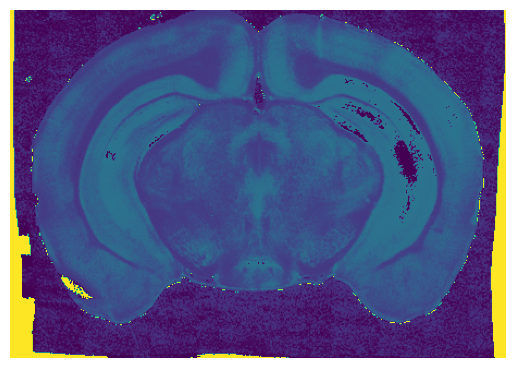

In [24]:
# Test the output
plt.axis('off')
plt.imshow(out[323,:,:])

In [25]:
data_gr_norm[323,:,:]

array([[0.  , 0.  , 0.  , ..., 1.7 , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 1.87, 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 1.7 , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

# Send volume data to unity

In [26]:
np.save("temp.npy",out)

In [29]:
out = np.load("temp.npy")

In [27]:
# urchin.clear()
urchin.volumes.create("histology")
urchin.volumes.set_colormap("histology", colormap)
urchin.volumes.set_data("histology", out)
urchin.volumes.set_visibility("histology",True)

(URN) disconnected from server
(URN) connected to server
Login sent with ID: bb02b571, copy this ID into the renderer to connect.


packet queue is empty, aborting


(URN) disconnected from server
(URN) connected to server
Login sent with ID: bb02b571, copy this ID into the renderer to connect.


packet queue is empty, aborting


(URN) disconnected from server
(URN) connected to server
Login sent with ID: bb02b571, copy this ID into the renderer to connect.


In [35]:
out.shape

(528, 320, 456)

In [37]:
528*320*456

77045760

packet queue is empty, aborting


(URN) disconnected from server
(URN) connected to server
Login sent with ID: c4c5a42e, copy this ID into the renderer to connect.


packet queue is empty, aborting


(URN) disconnected from server
(URN) connected to server
Login sent with ID: c4c5a42e, copy this ID into the renderer to connect.


packet queue is empty, aborting


(URN) disconnected from server
(URN) connected to server
Login sent with ID: c4c5a42e, copy this ID into the renderer to connect.


packet queue is empty, aborting


(URN) disconnected from server
(URN) connected to server
Login sent with ID: c4c5a42e, copy this ID into the renderer to connect.


In [36]:
type(out)

numpy.ndarray

(URN) disconnected from server
(URN) connected to server
Login sent with ID: c4c5a42e, copy this ID into the renderer to connect.
